c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\nbformat\__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 57 to 1271
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   week_start_dt     1215 non-null   object 
 1   week_end_dt       1215 non-null   object 
 2   vietnam_season    1215 non-null   int64  
 3   p_color           1215 non-null   object 
 4   price             1215 non-null   float64
 5   total_volume      1215 non-null   float64
 6   brazil            1215 non-null   float64
 7   india             1215 non-null   float64
 8   vietnam           1215 non-null   float64
 9   indonesia         1215 non-null   float64
 10  china             1215 non-null   float64
 11  brazil_season     1215 non-null   bool   
 12  indonesia_season  1215 non-null   bool   
 13  india_season      1215 non-null   bool   
 14  china_season      1215 non-null   bool   
 15  jordan_max_price  1215 non-null   float64
 16  jordan_min_price  1215 non-null   float64

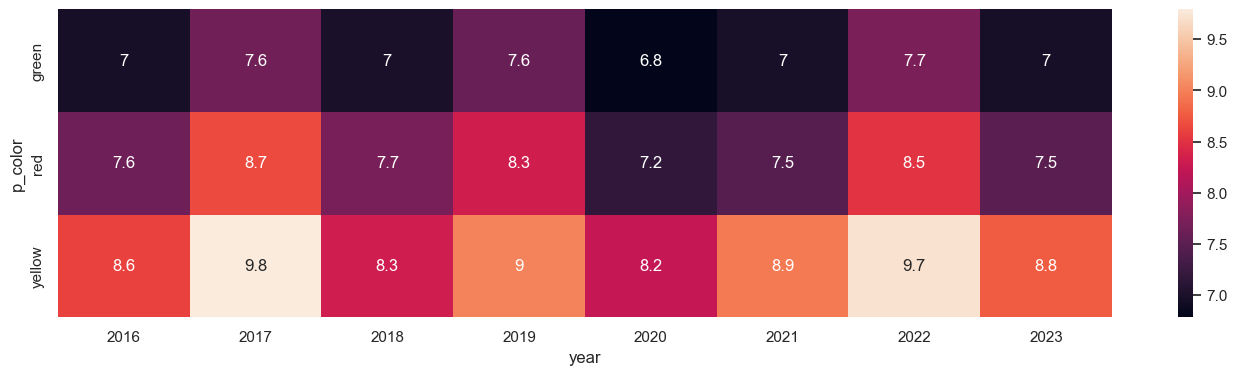

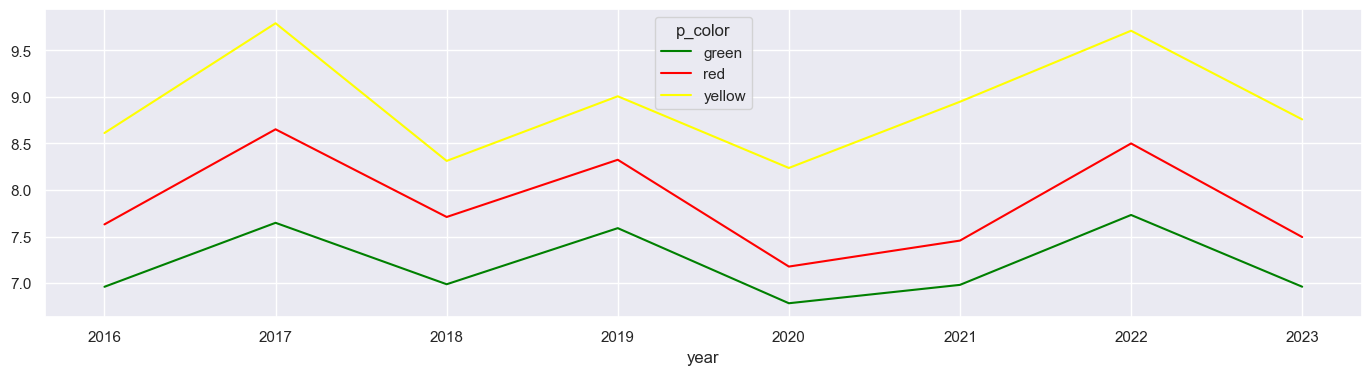

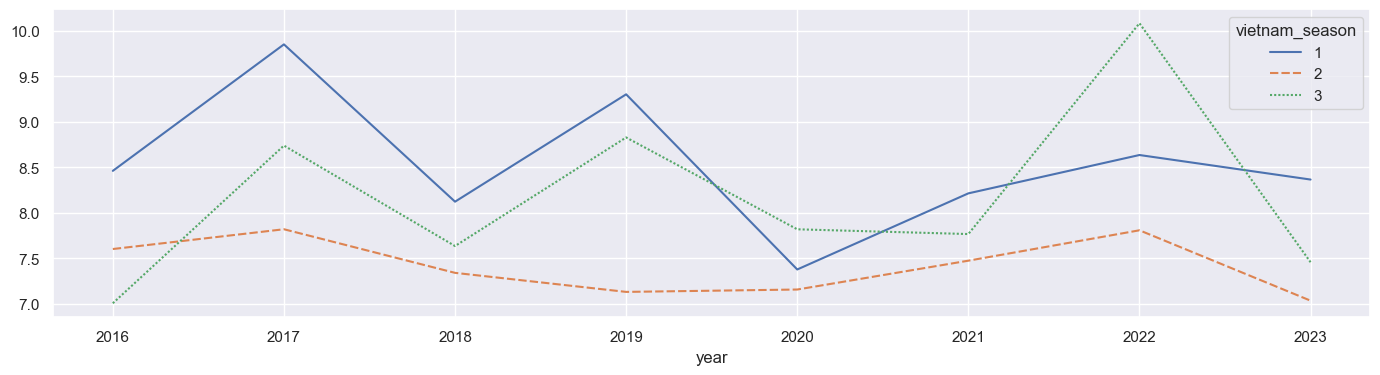

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.501     1.000-27201.805 27200.804
 (0 - 2)      0.082     1.000-27201.222 27201.387
 (0 - 3)   -221.504     1.000-27422.808 26979.800
 (0 - 4)    -86.517     1.000-27287.821 27114.787
 (0 - 5)  -8479.636     0.993-35680.941 18721.668
 (0 - 6) -245295.023     0.000-272496.327-218093.719
 (0 - 7) -28736.095     0.029-55937.400 -1534.791
 (0 - 8) -154940.070     0.000-182141.374-127738.766
 (0 - 9) -1806521.517     0.000-1833722.821-1779320.212
 (1 - 0)      0.501     1.000-27200.804 27201.805
 (1 - 2)      0.583     1.000-27200.722 27201.887
 (1 - 3)   -221.003     1.000-27422.308 26980.301
 (1 - 4)    -86.016     1.000-27287.321 27115.288
 (1 - 5)  -8479.136     0.993-35680.440 18722.169
 (1 - 6) -245294.522     0.000-272495.827-218093.218
 (1 - 7) -28735.595     0.029-55936.899 -1534.290
 (1 - 8) -154939.569     0.000-182140.874-127738.265
 (1 - 9) -1806

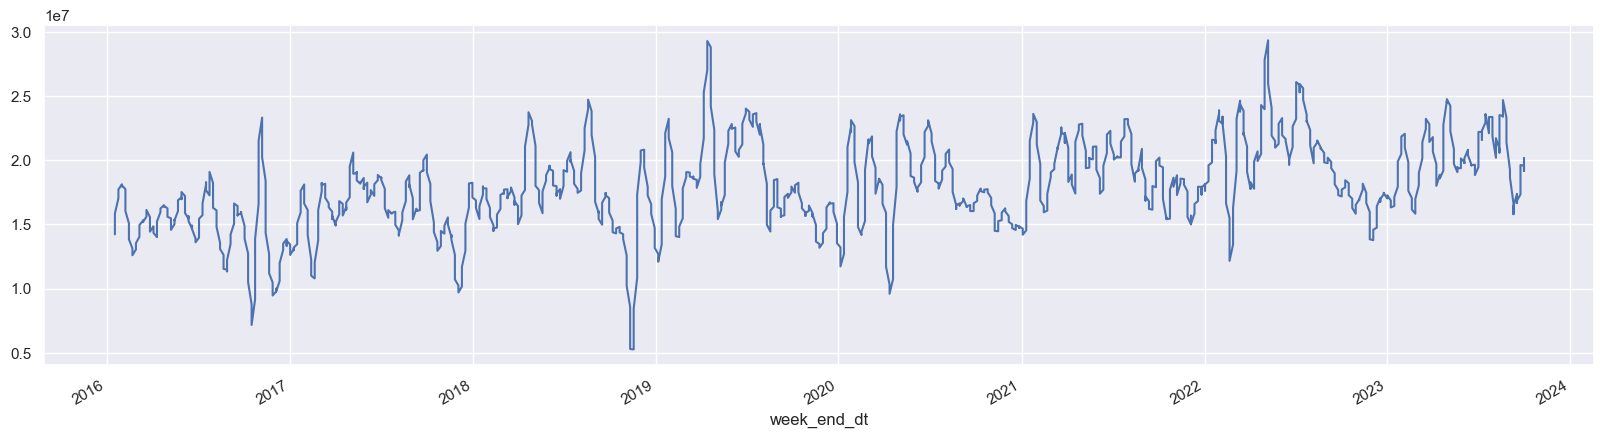

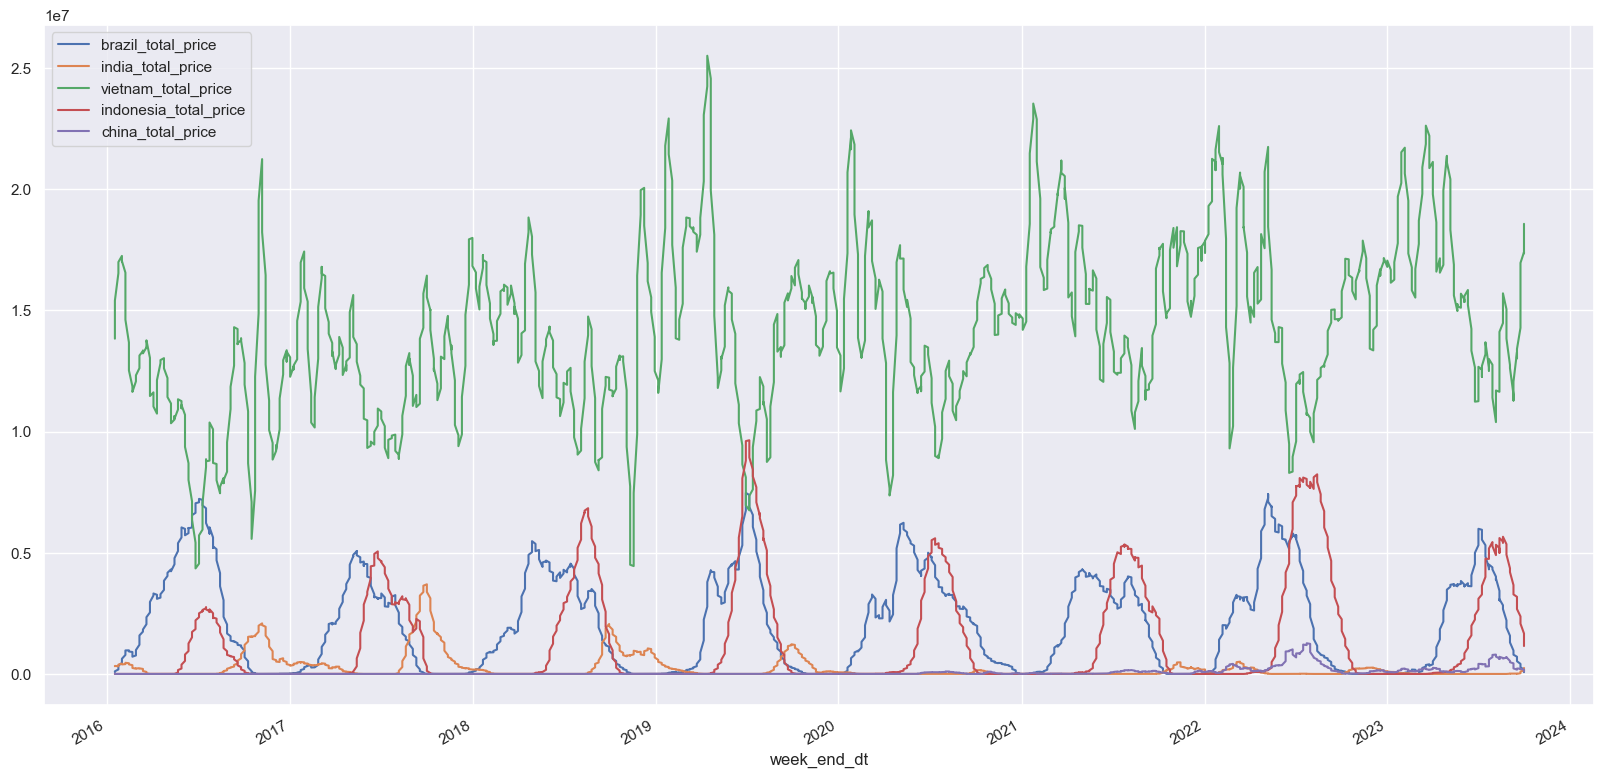

(405, 32) (405, 32) (405, 32)


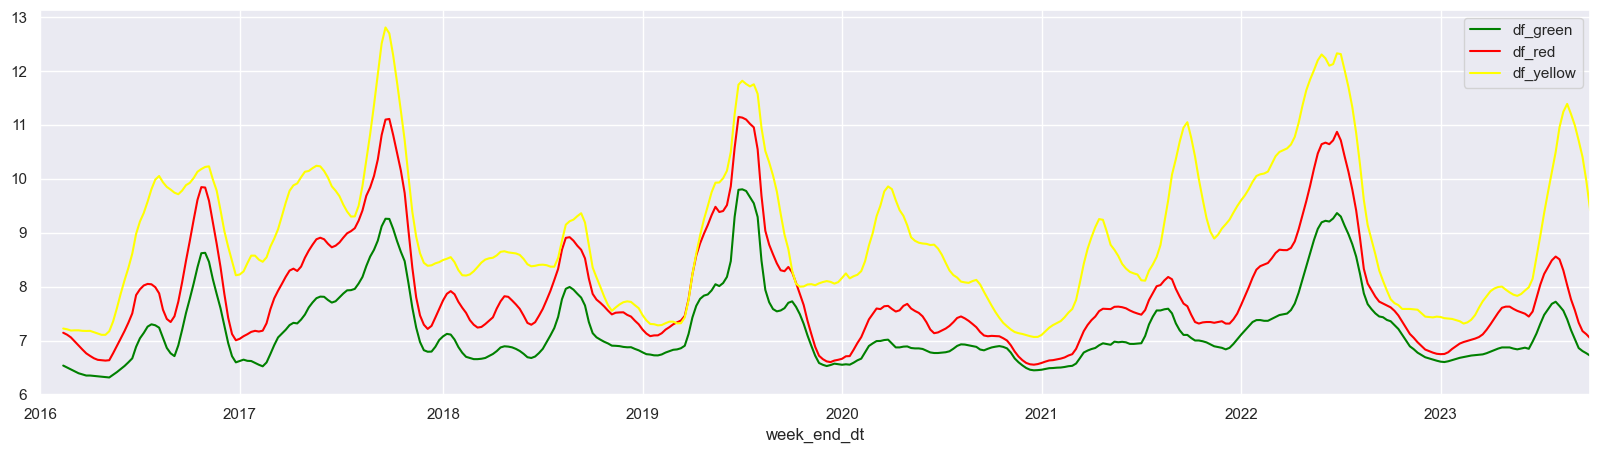

(405, 496) (405, 496) (405, 496)
(398, 473) (398, 473) (398, 473)


In [1]:
%run C:\Users\Omar\Intern_Final_Project\notebooks\Data_Cleaning\Features_Engineering.ipynb

### *cross validation*

*We will keep the last 16 rows of the dataset and do a Rolling Moving Origin of step size of 4*


*lets explain this visually*

In [2]:
from sklearn.model_selection import TimeSeriesSplit

In [3]:
test_data_red=df_red[-16:]
#####
X = test_data_red.drop("price",axis=1)
y = test_data_red["price"]
date=test_data_red.reset_index()["week_end_dt"]
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[4 5 6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[ 8  9 10 11]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14 15]


The above code out come expresess how the cross validation works ,
1st fold : we consider the 4 intial points as train data and the next 4 points as test data
2ns fold : the test points from the prevuoys fold we be appened to the new train points asnd new points ahead are test points
3rd fold : works as metioned above

The below chart is ease the process:


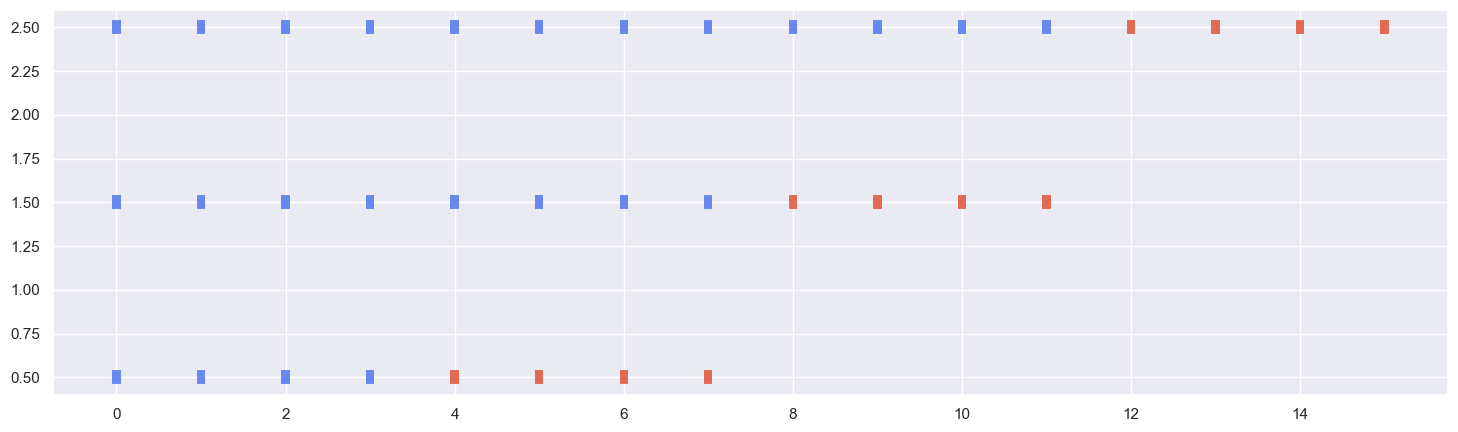

In [4]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, n_splits, X, y):
    fig, ax = plt.subplots(1, 1, figsize = (18, 5))
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
plot_cv_indices(cv=tscv,n_splits=3,X=X,y=y)

---
importing needed libraries

In [5]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_tree,plot_importance,XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm.sklearn import LGBMRegressor
import warnings                                  
warnings.filterwarnings('ignore')

In [6]:
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)

In [7]:
mape_scores = []
y_pred_red_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                    "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
                XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]

test_data_red=df_red[-16:]      
time_series_data_red = test_data_red.values

for train_index, test_index in tscv.split(time_series_data_red):
              X_train, y_train = time_series_data_red[train_index, 1:], time_series_data_red[train_index, 0]
              X_test, y_test = time_series_data_red[test_index, 1:], time_series_data_red[test_index, 0]

        
for model in models:
              model.fit(X_train, y_train)
              y_pred_red = model.predict(X_test)
              y_pred_red_results.append(y_pred_red)

              mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_red))
              mape_scores.append(mape)

              mape_red=pd.concat([pd.DataFrame(models_names,columns=["models_names"]),pd.DataFrame(mape_scores,columns=["mape_scores"])],axis=1)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 0
[LightGBM] [Info] Start training from score 8.050651
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

In [8]:
pred_results_red=pd.DataFrame(y_pred_red_results).T
pred_results_red.columns=models_names
pred_results_red

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,6.984959,7.231440,7.714819,6.506290,7.388713,7.096125,6.984959,8.050651,7.209486
1,7.782990,7.364474,7.718163,6.354556,7.043673,7.096125,7.209757,8.050651,7.453657
2,7.782990,7.439441,7.736490,6.895536,7.043673,7.128633,7.209757,8.050651,7.561851
3,7.782990,7.543791,7.752334,6.349882,7.604617,7.168093,7.209757,8.050651,7.646939


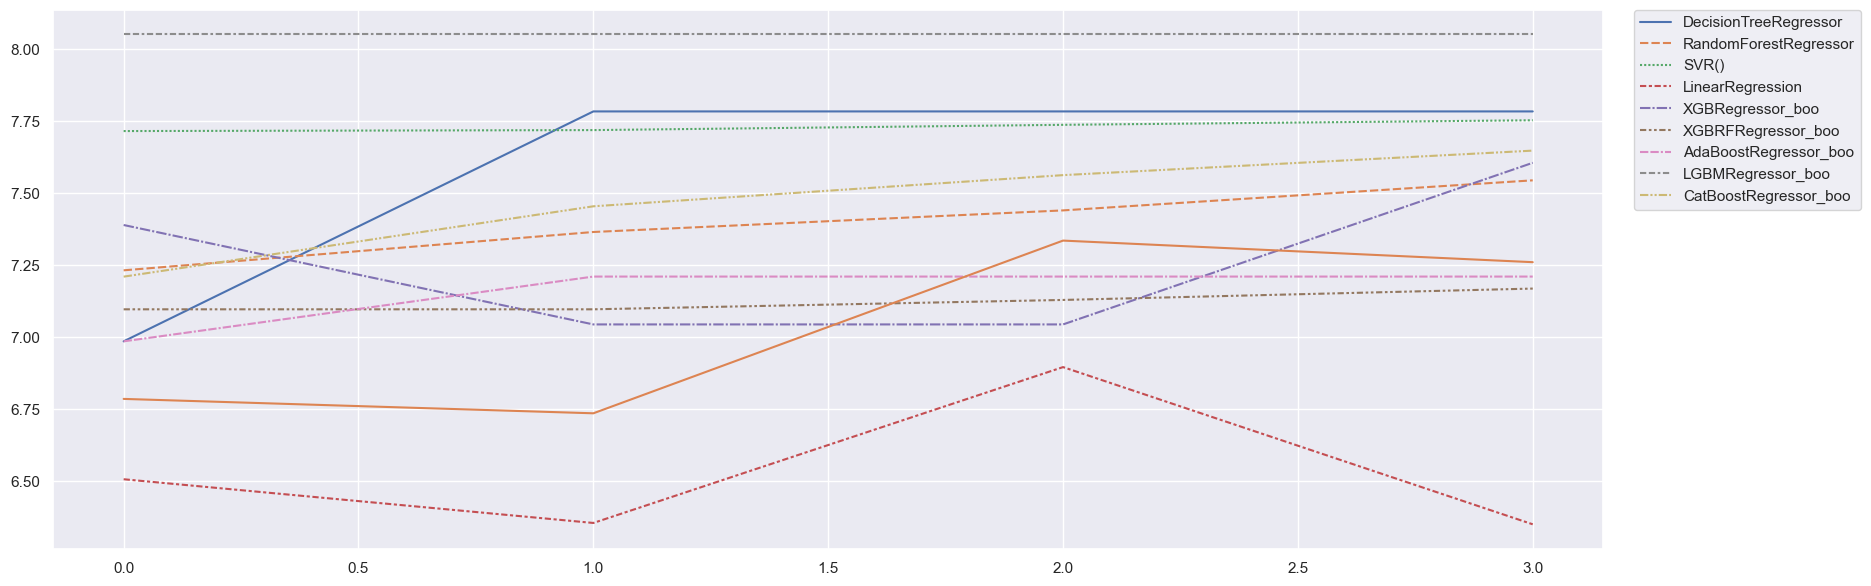

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (20,7))
sns.lineplot(pred_results_red,legend=True)
sns.lineplot(y_test,legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
mape_scores = []
y_pred_green_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                    "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
                XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]
     
test_data_green=df_green[-16:]
time_series_data_green = test_data_green.values

for train_index, test_index in tscv.split(time_series_data_green):
              X_train, y_train = time_series_data_green[train_index, 1:], time_series_data_green[train_index, 0]
              X_test, y_test = time_series_data_green[test_index, 1:], time_series_data_green[test_index, 0]
        
        
for model in models:
              model.fit(X_train, y_train)
              y_pred_green = model.predict(X_test)
              y_pred_green_results.append(y_pred_green)

              mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_green))
              mape_scores.append(mape)

              mape_green =pd.concat([pd.DataFrame(models_names,columns=["models_names"]),pd.DataFrame(mape_scores,columns=["mape_scores"])],axis=1)

In [11]:
pred_results_green=pd.DataFrame(y_pred_green_results).T
pred_results_green.columns=models_names
pred_results_green

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,7.234734,6.701859,7.167312,6.287681,6.560656,6.647105,6.560342,7.372297,6.806190
1,6.885049,6.790500,7.170719,6.365702,6.560656,6.658822,6.885049,7.372297,6.978668
2,7.732530,6.822685,7.191289,7.289985,6.598741,6.685033,6.885049,7.372297,7.005496
3,7.961280,6.871000,7.208736,7.345109,6.640180,6.682138,6.885049,7.372297,7.039876


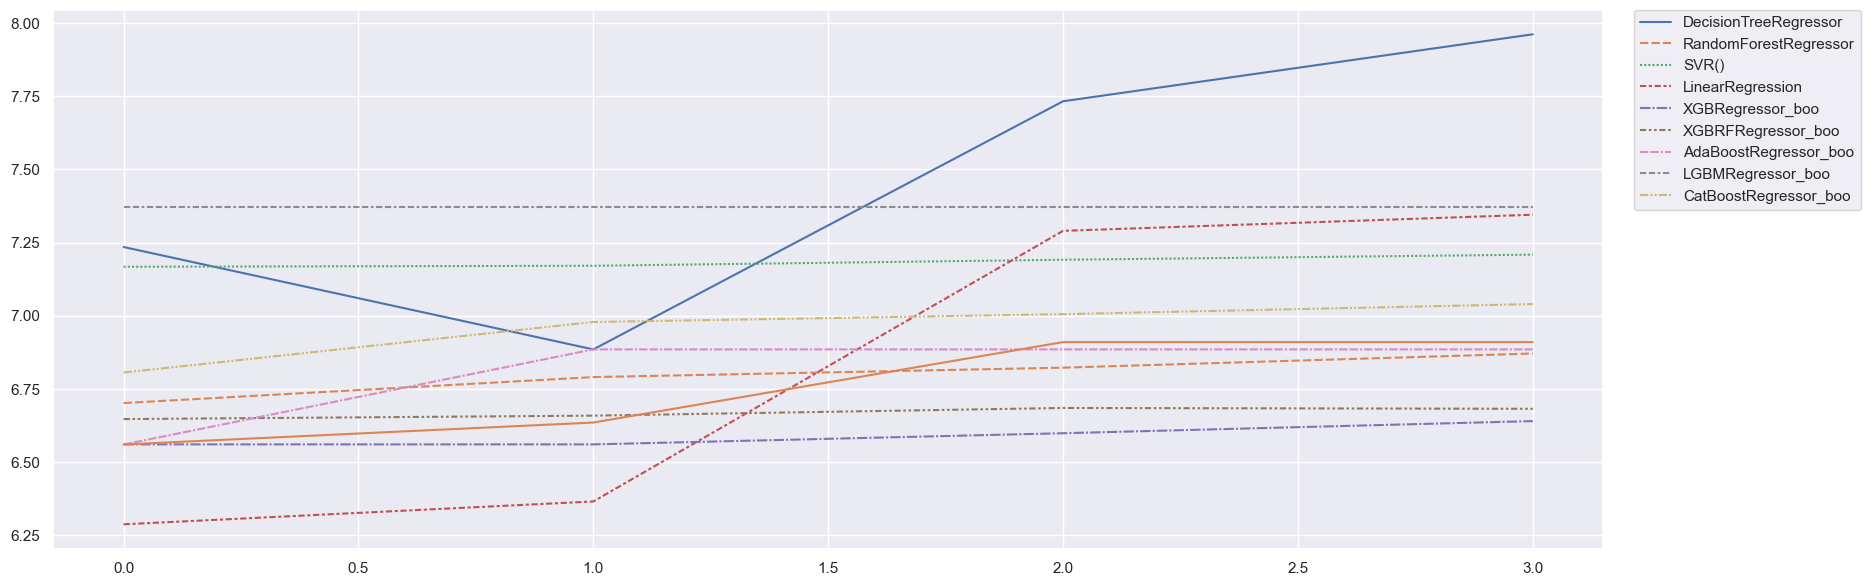

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20,7))
sns.lineplot(pred_results_green,legend=True)
sns.lineplot(y_test,legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
mape_scores = []
y_pred_yellow_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
            XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]
     
test_data_yellow=df_yellow[-16:]
time_series_data_yellow = test_data_yellow.values

for train_index, test_index in tscv.split(time_series_data_yellow):
              X_train, y_train = time_series_data_yellow[train_index, 1:], time_series_data_yellow[train_index, 0]
              X_test, y_test = time_series_data_yellow[test_index, 1:], time_series_data_yellow[test_index, 0]
        

for model in models:
              model.fit(X_train, y_train)
              y_pred_yellow = model.predict(X_test)
              y_pred_yellow_results.append(y_pred_yellow)

              mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_yellow))
              mape_scores.append(mape)

              mape_yellow=pd.concat([pd.DataFrame(models_names,columns=["models_names"]),pd.DataFrame(mape_scores,columns=["mape_scores"])],axis=1)

In [14]:
pred_results_yellow=pd.DataFrame(y_pred_yellow_results).T
pred_results_yellow.columns=models_names
pred_results_yellow

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,9.432754,9.709131,10.795924,9.125548,9.946124,9.637501,9.432754,10.711343,9.788087
1,9.432754,10.004640,10.789981,8.465031,10.432939,9.849808,9.432754,10.711343,10.125917
2,8.919780,9.741281,10.745475,7.579278,10.432939,9.618520,9.432754,10.711343,9.985871
3,8.919780,9.797079,10.695217,5.200643,9.515014,9.566567,9.432754,10.711343,10.050787


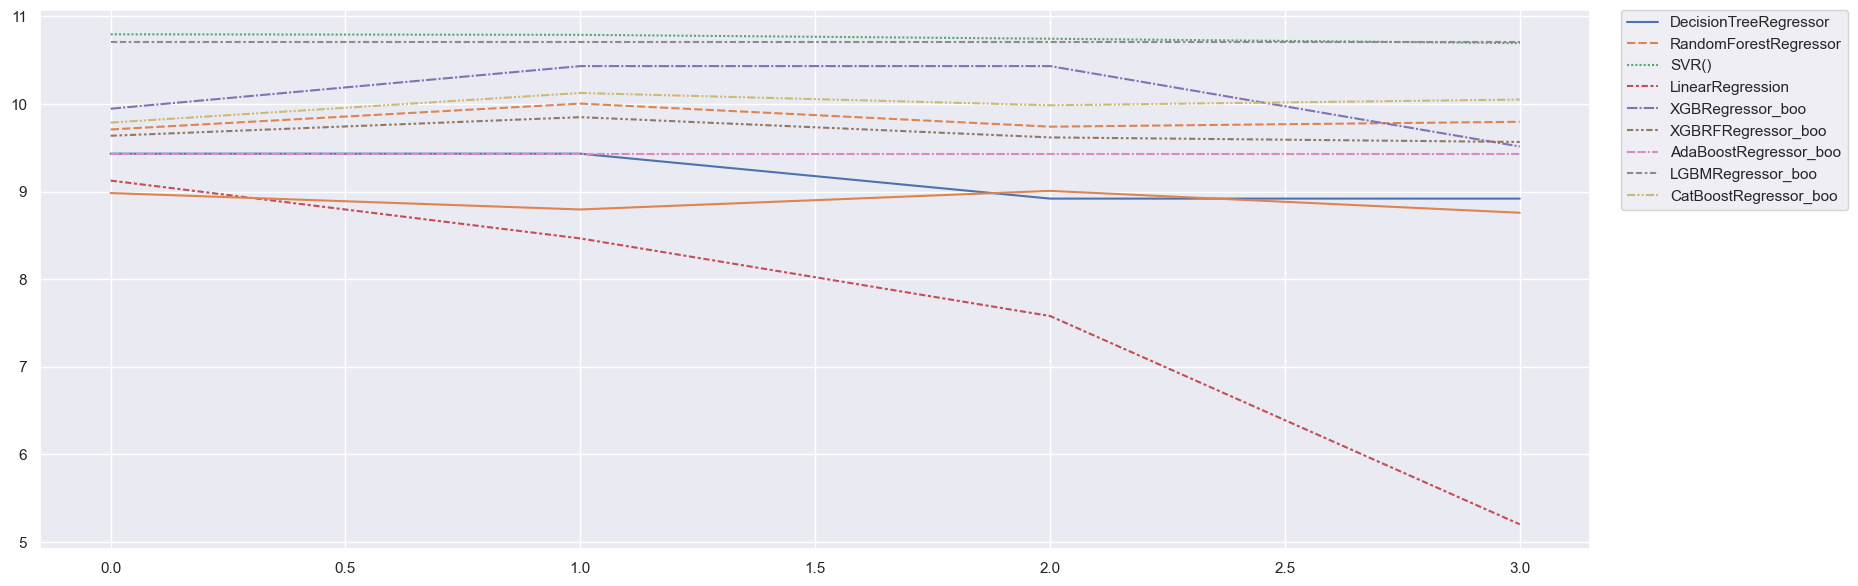

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (20,7))
sns.lineplot(pred_results_yellow,legend=True)
sns.lineplot(y_test,legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [16]:
mape_red.sort_values(by="mape_scores")

,models_names,mape_scores
6,AdaBoostRegressor_boo,0.030955
5,XGBRFRegressor_boo,0.035033
1,RandomForestRegressor,0.053157
4,XGBRegressor_boo,0.055485
8,CatBoostRegressor_boo,0.063383
3,LinearRegression,0.070701
0,DecisionTreeRegressor,0.079557
2,SVR(),0.101402
7,LGBMRegressor_boo,0.147098


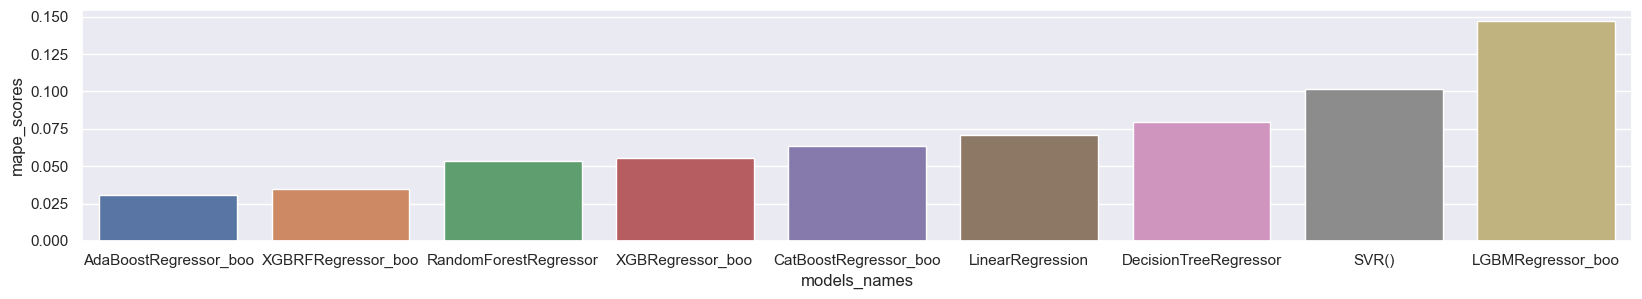

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=mape_red.sort_values(by="mape_scores"),x="models_names",y="mape_scores");

In [18]:
mape_green.sort_values(by="mape_scores")

,models_names,mape_scores
6,AdaBoostRegressor_boo,0.011218
1,RandomForestRegressor,0.015813
5,XGBRFRegressor_boo,0.020579
4,XGBRegressor_boo,0.023848
8,CatBoostRegressor_boo,0.030459
3,LinearRegression,0.050035
2,SVR(),0.064287
7,LGBMRegressor_boo,0.092160
0,DecisionTreeRegressor,0.102902


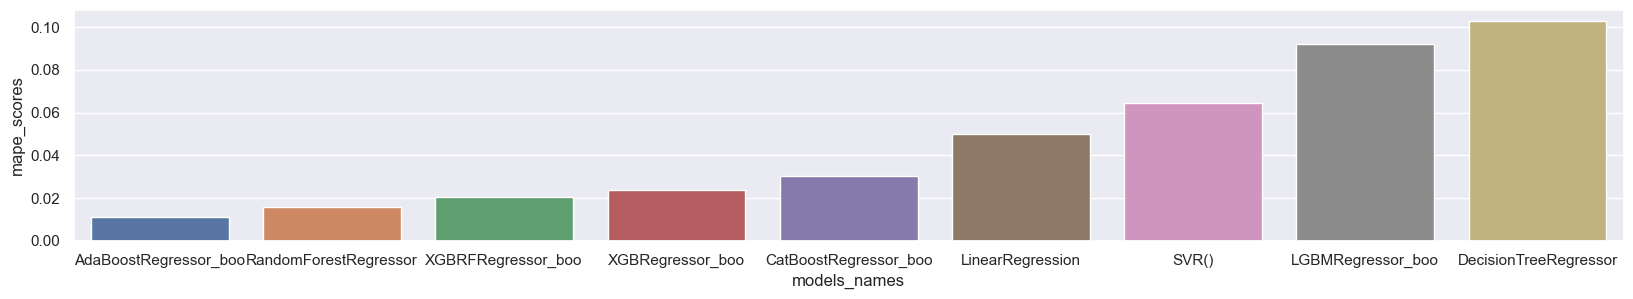

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=mape_green.sort_values(by="mape_scores"),x="models_names",y="mape_scores");

In [20]:
mape_yellow.sort_values(by="mape_scores")

,models_names,mape_scores
0,DecisionTreeRegressor,0.037675
6,AdaBoostRegressor_boo,0.061649
5,XGBRFRegressor_boo,0.088176
1,RandomForestRegressor,0.104557
8,CatBoostRegressor_boo,0.124231
4,XGBRegressor_boo,0.134470
3,LinearRegression,0.154571
7,LGBMRegressor_boo,0.205554
2,SVR(),0.210630


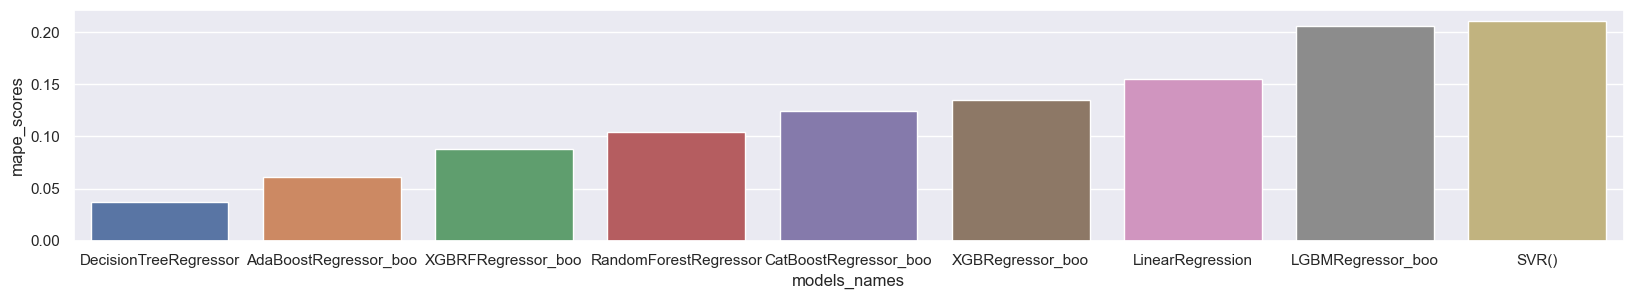

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=mape_yellow.sort_values(by="mape_scores"),x="models_names",y="mape_scores");

###  *Hyperparamers tunning*

#### *We will consider the best model performed above for each color*

##### *Red color*<br>
* *The best performed model was XGBRFRegressor_boo with mape =0.032385*

In [22]:
time_series_data_red = test_data_red.values
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)


for train_index, test_index in tscv.split(time_series_data_red):
              X_train, y_train = time_series_data_red[train_index, 1:], time_series_data_red[train_index, 0]
              X_test, y_test = time_series_data_red[test_index, 1:], time_series_data_red[test_index, 0]

              xgbrfregressor_parm=[{"n_estimators":[10,20,50,75,100,200],
                                       "max_depth":[5,10,15,20],
                                       "num_parallel_tree":[50,100,150,200],
                                       "subsample": [.7,.8,.9,.6,.5],
                                       "colsample_bynode": [.7,.8,.9,.6,.5] }]
                                           
               
              xgbrfregressor_RandoSeaCV=RandomizedSearchCV(XGBRFRegressor(),param_distributions=xgbrfregressor_parm,n_jobs=-1,cv=4,random_state=0)
              xgbrfregressor_RandoSeaCV.fit(X_train, y_train)
              new_xgbrfregressor=xgbrfregressor_RandoSeaCV.best_estimator_.fit(X_train, y_train)
              new_xgbrfregressor.predict(X_test)



print("The best parameters are :",xgbrfregressor_RandoSeaCV.best_params_)
print("The new mean_absolute_percentage_error after using the best parametes is: ",mean_absolute_percentage_error(y_test,new_xgbrfregressor.predict(X_test)))

The best parameters are : {'subsample': 0.9, 'num_parallel_tree': 50, 'n_estimators': 100, 'max_depth': 20, 'colsample_bynode': 0.5}
The new mean_absolute_percentage_error after using the best parametes is:  0.06760489348302304


##### *Green color*
* *The best performed model was AdaBoostRegressor_boo  with mape= 0.011218*

In [23]:
time_series_data_green = test_data_green.values
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)


for train_index, test_index in tscv.split(time_series_data_green):
              X_train, y_train = time_series_data_green[train_index, 1:], time_series_data_green[train_index, 0]
              X_test, y_test = time_series_data_green[test_index, 1:], time_series_data_green[test_index, 0]

              AdaBoostRegressor_parm=[{"n_estimators":[10,20,50,75,100,200],
                                       #"estimator":[" DecisionTreeRegressor","LinearRegression","SVR"],
                                       "learning_rate":[0.1,.01,.001,.0125,0.0058],
                                       "loss":['linear', 'square', 'exponential'] }]     
               
              AdaBoostRegressor_RandoSeaCV=RandomizedSearchCV(AdaBoostRegressor(random_state=0),param_distributions=AdaBoostRegressor_parm,n_jobs=-1,cv=4,random_state=0)
              AdaBoostRegressor_RandoSeaCV.fit(X_train, y_train)
              new_AdaBoostRegressor=AdaBoostRegressor_RandoSeaCV.best_estimator_.fit(X_train, y_train)
              new_AdaBoostRegressor.predict(X_test)




print("The best parameters are :",AdaBoostRegressor_RandoSeaCV.best_params_)
print("The new mean_absolute_percentage_error after using the best parametes is: ",mean_absolute_percentage_error(y_test,new_AdaBoostRegressor.predict(X_test)))

The best parameters are : {'n_estimators': 20, 'loss': 'exponential', 'learning_rate': 0.1}
The new mean_absolute_percentage_error after using the best parametes is:  0.004630600505221465


##### *Yellow color*
* *The best performed model was with mape =0.061649* 

In [24]:
time_series_data_yellow = test_data_yellow.values
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)


for train_index, test_index in tscv.split(time_series_data_yellow):
              X_train, y_train = time_series_data_yellow[train_index, 1:], time_series_data_yellow[train_index, 0]
              X_test, y_test = time_series_data_yellow[test_index, 1:], time_series_data_yellow[test_index, 0]

              DecisionTreeRegressor_parm=[{
                    "min_samples_split":[2,10,20,30,40,50],                                          
                    "max_features":["sqrt","log2"],                                     
                     "max_depth":[int(x) for x in np.linspace(start=10,stop=200,num=10)]}]       
              DecisionTreeRegressor_RandoSeaCV=RandomizedSearchCV(DecisionTreeRegressor(random_state=0),param_distributions=DecisionTreeRegressor_parm,n_jobs=-1,cv=4,random_state=0)
              DecisionTreeRegressor_RandoSeaCV.fit(X_train, y_train)   
              new_DecisionTreeRegressor=DecisionTreeRegressor_RandoSeaCV.best_estimator_.fit(X_train, y_train)
              new_DecisionTreeRegressor.predict(X_test)




print("The best parameters are :",DecisionTreeRegressor_RandoSeaCV.best_params_)
print("The new mean_absolute_percentage_error after using the best parametes is: ",mean_absolute_percentage_error(y_test,new_DecisionTreeRegressor.predict(X_test)))

           

The best parameters are : {'min_samples_split': 40, 'max_features': 'log2', 'max_depth': 157}
The new mean_absolute_percentage_error after using the best parametes is:  0.20555367650795453
